In [1]:
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly import tools
import seaborn as sns
import calendar
from wordcloud import WordCloud, STOPWORDS
from wordcloud import WordCloud
from textblob import TextBlob 
import string, os, random
from PIL import Image

import folium 
from folium import plugins 


init_notebook_mode(connected=True)
punc = string.punctuation
from datetime import datetime

# Load the dataset
path = "gun-violence-data_01-2013_03-2018.csv"

# path = "gun-violence.xls"
df = pd.read_csv(path) 

### Fix a row in the dataset 
### According to the author of this dataset, one particular incident is missing from the dataset 
### Related Thread: https://www.kaggle.com/jameslko/gun-violence-data/discussion/55307
missing_row = ['sban_1', '2017-10-01', 'Nevada', 'Las Vegas', 'Mandalay Bay 3950 Blvd S', 59, 489, 'https://en.wikipedia.org/wiki/2017_Las_Vegas_shooting', 'https://en.wikipedia.org/wiki/2017_Las_Vegas_shooting', '-', '-', '-', '-', '-', '36.095', 'Hotel', 
               '-115.171667', 47, 'Route 91 Harvest Festiva; concert, open fire from 32nd floor. 47 guns seized; TOTAL:59 kill, 489 inj, number shot TBD,girlfriend Marilou Danley POI', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
df.loc[len(df)] = missing_row

# dropping passed columns 
df.drop(["incident_url", "source_url", "incident_url_fields_missing", "sources", "state_house_district"], axis = 1, inplace = True) 

# Create some additional features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['loss'] = df['n_killed'] + df['n_injured']

df

,incident_id,date,state,city_or_county,address,n_killed,n_injured,congressional_district,gun_stolen,gun_type,...,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,state_senate_district,year,month,loss
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,14,NaN,NaN,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,2013,1,4
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,43,NaN,NaN,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,35,2013,1,4
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,9,0::Unknown||1::Unknown,0::Unknown||1::Unknown,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,13,2013,1,4
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,6,NaN,NaN,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,28,2013,1,4
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,6,0::Unknown||1::Unknown,0::Handgun||1::Handgun,...,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,27,2013,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239673,1083139,2018-03-31,Louisiana,Natchitoches,247 Keyser Ave,1,0,4,0::Unknown,0::Unknown,...,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Jamal Haskett||1::Jaquarious Tyjuan Ardison,NaN,"0::Killed||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,31,2018,3,1
239674,1083151,2018-03-31,Louisiana,Gretna,1300 block of Cook Street,0,1,2,0::Unknown,0::Unknown,...,0::Adult 18+,0::Male,NaN,NaN,0::Injured,0::Victim,7,2018,3,1
239675,1082514,2018-03-31,Texas,Houston,12630 Ashford Point Dr,1,0,9,0::Unknown,0::Unknown,...,0::Adult 18+,0::Male,0::Leroy Ellis,NaN,0::Killed,0::Victim,17,2018,3,1
239676,1081940,2018-03-31,Maine,Norridgewock,434 Skowhegan Rd,2,0,2,0::Unknown||1::Unknown,0::Handgun||1::Shotgun,...,0::Adult 18+||1::Adult 18+,0::Female||1::Male,0::Marie Lancaster Hale||1::William Hale,1::Significant others - current or former,0::Killed||1::Killed,0::Victim||1::Subject-Suspect,3,2018,3,2


In [2]:
# Incidents by year

# function to aggregate and return keys and values
def create_stack_bar_data(col):
    aggregated = df[col].value_counts()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values

x1, y1 = create_stack_bar_data('year')
x1 = x1[:-1]
y1 = y1[:-1]
trace1 = go.Bar(x=x1, y=y1, opacity=0.9, name="year count", marker=dict(color=['rgba(255, 102, 102, 0.8)', 'rgba(51, 204, 204, 0.8)', 'rgba(102, 153, 255, 0.8)', 'rgba(12, 220, 150, 0.8)', 'rgba(204, 0, 153,0.8)']))
layout = dict(height=500, title='Gun Violence Incidents by year', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [3]:
# Incidents by month

tempdf = df[df['year'].isin(['2014','2015','2016','2017'])]
tempdf1 = tempdf.groupby(['year','month']).agg({'month' : 'count'}).rename(columns={'month': 'month_count'}).reset_index()
aggregated = tempdf1.groupby(['month']).agg({'month_count' : 'mean'})
x2 = aggregated.index.tolist()
y2 = aggregated.month_count.tolist()
mapp = {}
for m,v in zip(x2, y2):
    mapp[m] = v
xn = [calendar.month_abbr[int(x)] for x in sorted(x2)]
vn = [mapp[x] for x in sorted(x2)]

trace1 = go.Bar(x=xn, y=vn, opacity=0.9, name="month", marker=dict(color='rgba(255, 102, 102, 0.8)'))
layout = dict(height=600, title='Average number of Incidents by Months', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig, filename='stacked-bar')

In [4]:
# Incidents time series

# 2014 time series
temp = df[df['year'] == 2014].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})


trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350, title = 'Gun Violence Incidents - 2014', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)



# 2015 time series
temp = df[df['year'] == 2015].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})


trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350, title = 'Gun Violence Incidents - 2015', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)





# 2016 time series
temp = df[df['year'] == 2016].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})


trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350,title = 'Gun Violence Incidents - 2016', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)


# 2017 time series
temp = df[df['year'] == 2017].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})


trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350,title = 'Gun Violence Incidents - 2017', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)

# 2018 time series
temp = df[df['year'] == 2018].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})


trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350, title = 'Gun Violence Incidents - 2018', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)

In [5]:
# Incidents on special dates

df['day'] = df['date'].dt.day
special_days= df.loc[(df['month']==12) & (df['day']==25)]
# special_days

new_year = df.loc[(df['month']==1) & (df['day']==1)]
special_days = pd.concat([new_year,special_days])

halloween = df.loc[(df['month']==10) & (df['day']==31)]
special_days = pd.concat([halloween,special_days])

independence_day = df.loc[(df['month']==6) & (df['day']==4)]
special_days = pd.concat([independence_day,special_days])

st_patrick_day = df.loc[(df['month']==3) & (df['day']==17)]
special_days = pd.concat([st_patrick_day,special_days])

valentines_day = df.loc[(df['month']==2) & (df['day']==14)]
special_days = pd.concat([valentines_day,special_days])

martin_luther_day = df.loc[(df['month']==1) & (df['day']==18)]
special_days = pd.concat([martin_luther_day,special_days])

x1, y1 = create_stack_bar_data('year')
x1 = x1[:-1]
y1 = y1[:-1]
trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="year count", marker=dict(color=['rgba(10, 220, 150, 0.6)', 'rgba(10, 220, 150, 0.6)', 'rgba(10, 220, 150, 0.6)', 'rgba(10, 220, 150, 0.6)', 'rgba(222,45,38,0.8)']))
layout = dict(height=400, title='Gun Violence Incidents by year on special days', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [6]:
event_dictionary ={1 : 'new year', 31 : 'halloween', 25 : 'christmas', 4:'independence day', 17 : "st. patrick's day", 14 : 'valentines day', 18:'martin luther day'}
        
def set_value(row_number, assigned_value): 
    return assigned_value[row_number]
special_days['holiday'] = special_days['day'].apply(set_value, args =(event_dictionary, ))

def create_stack_bar_data(col):
    aggregated = special_days[col].value_counts()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values
x1, y1 = create_stack_bar_data('holiday')
x1 = x1[:]
y1 = y1[:]
trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="year count", marker=dict(color=['rgba(10, 220, 150, 0.6)', 'rgba(10, 220, 150, 0.6)', 'rgba(10, 220, 150, 0.6)', 'rgba(10, 220, 150, 0.6)', 'rgba(222,45,38,0.8)']))
layout = dict(height=400, title='Total No. of Incidents on special days', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [7]:
# Incidents in US

smalldf = df[df['n_killed'] >= 3][['latitude', 'longitude', 'loss', 'n_killed']].dropna()
map1 = folium.Map(location=[39.50, -98.35], tiles='CartoDB dark_matter', zoom_start=3.5)
map2 = folium.Map([39.50, -98.35], zoom_start=3.5, tiles='cartodbdark_matter')
markers = []
for i, row in smalldf.iterrows():
    loss = row['loss']
    if row['loss'] > 100:
        loss = row['loss']*0.1    
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(loss), color='#ef4f61', fill=True).add_to(map1)
    
map1

In [8]:
# Incidents by state
# Statewise incidents

states_df = df['state'].value_counts()

statesdf = pd.DataFrame()
statesdf['state'] = states_df.index
statesdf['counts'] = states_df.values

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

state_to_code = {'District of Columbia' : 'dc','Mississippi': 'MS', 'Oklahoma': 'OK', 'Delaware': 'DE', 'Minnesota': 'MN', 'Illinois': 'IL', 'Arkansas': 'AR', 'New Mexico': 'NM', 'Indiana': 'IN', 'Maryland': 'MD', 'Louisiana': 'LA', 'Idaho': 'ID', 'Wyoming': 'WY', 'Tennessee': 'TN', 'Arizona': 'AZ', 'Iowa': 'IA', 'Michigan': 'MI', 'Kansas': 'KS', 'Utah': 'UT', 'Virginia': 'VA', 'Oregon': 'OR', 'Connecticut': 'CT', 'Montana': 'MT', 'California': 'CA', 'Massachusetts': 'MA', 'West Virginia': 'WV', 'South Carolina': 'SC', 'New Hampshire': 'NH', 'Wisconsin': 'WI', 'Vermont': 'VT', 'Georgia': 'GA', 'North Dakota': 'ND', 'Pennsylvania': 'PA', 'Florida': 'FL', 'Alaska': 'AK', 'Kentucky': 'KY', 'Hawaii': 'HI', 'Nebraska': 'NE', 'Missouri': 'MO', 'Ohio': 'OH', 'Alabama': 'AL', 'Rhode Island': 'RI', 'South Dakota': 'SD', 'Colorado': 'CO', 'New Jersey': 'NJ', 'Washington': 'WA', 'North Carolina': 'NC', 'New York': 'NY', 'Texas': 'TX', 'Nevada': 'NV', 'Maine': 'ME'}
statesdf['state_code'] = statesdf['state'].apply(lambda x : state_to_code[x])

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = statesdf['state_code'],
        z = statesdf['counts'],
        locationmode = 'USA-states',
        text = statesdf['state'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Gun Violence Incidents")
        ) ]

layout = dict(
        title = 'State wise number of Gun Violence Incidents',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

In [9]:
# Incidents with loss by state
statdf = df.reset_index().groupby(by=['state']).agg({'loss':'sum', 'year':'count'}).rename(columns={'year':'count'})
statdf['state'] = statdf.index

trace1 = go.Bar(
    x=statdf['state'],
    y=statdf['count'],
    name='Count of Incidents',
    marker=dict(color='rgb(255,10,225)'),
    opacity=0.6
)
trace2 = go.Bar(
    x=statdf['state'],
    y=statdf['loss'],
    name='Total Loss',
    marker=dict(color='rgb(58,22,225)'),
    opacity=0.6
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    margin=dict(b=150),
    legend=dict(dict(x=-.1, y=1.2)),
    title = 'State wise number of Gun Violence Incidents and Total Loss',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

In [10]:
# 20 states of violence
temp = df["state"].value_counts().head(20)
trace = go.Bar(
    x=temp.index,
    y=temp.values,
    marker=dict(
        color=temp.values,
        colorscale = 'Picnic'
    ),
)

layout = go.Layout(
    title='Top 20 states with max. Gun Violence'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

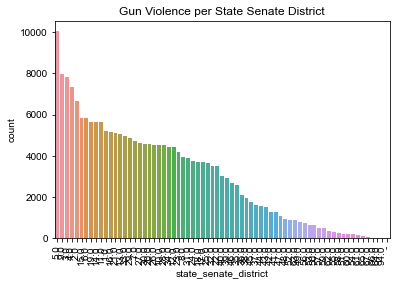

In [11]:
# Incidents by state senate district
senate = sns.countplot(x=df.state_senate_district, data=df, order=df.state_senate_district.value_counts().index)
senate.set_xticklabels(senate.get_xticklabels(), rotation=90)
senate.set_title("Gun Violence per State Senate District")
sns.set(rc={'figure.figsize':(14,16)})
plt.show()

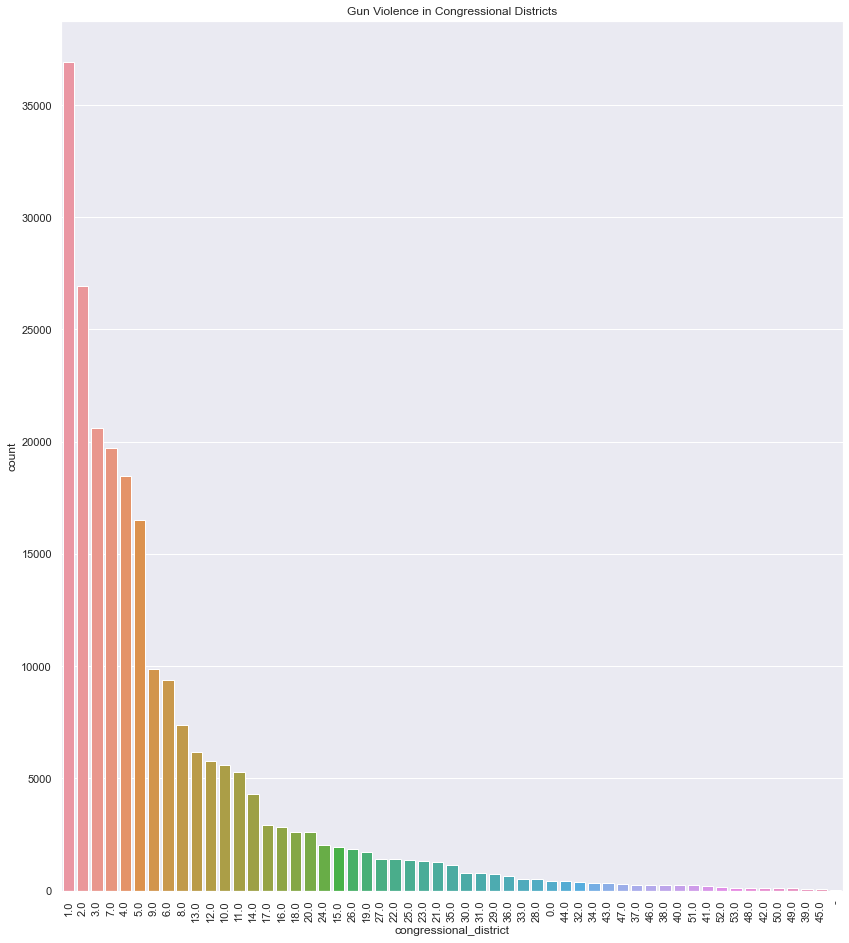

In [12]:
# Incidents by congressional district

senate = sns.countplot(x=df.congressional_district, data=df, order=df.congressional_district.value_counts().index)
senate.set_xticklabels(senate.get_xticklabels(), rotation=90)
senate.set_title("Gun Violence in Congressional Districts")
sns.set(rc={'figure.figsize':(12,8)})
plt.show()

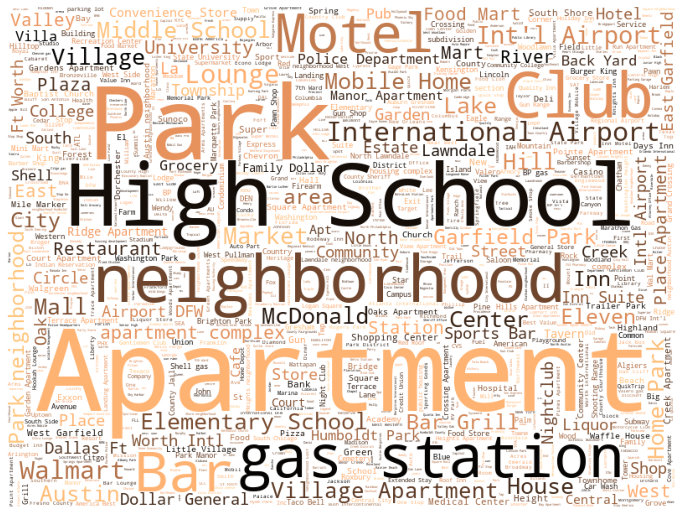

In [13]:
# Areas of gun violence
frequencies = df['location_description'].value_counts().to_dict()

txt = " ".join(df['location_description'].dropna())
wc = WordCloud(height=600, width=800, max_words=1200, stopwords=STOPWORDS, colormap='copper', background_color='White').generate(txt)
plt.figure(figsize=(12,12))
plt.imshow(wc)
plt.axis('off')
plt.title('');
plt.show()

In [14]:
# Trends by age
def get_user_mapping(txt):
    if txt == "NA":
        return {}
    mapping = {}
    for d in txt.split("||"):
        try:
            key = d.split("::")[0]
            val = d.split("::")[1]
            if key not in mapping:
                mapping[key] = val
        except:
            pass
    return mapping

df['participant_type'] = df['participant_type'].fillna("NA")
df['participant_type_map'] = df['participant_type'].apply(lambda x : get_user_mapping(x))
df['participant_age'] = df['participant_age'].fillna("NA")
df['participant_age_map'] = df['participant_age'].apply(lambda x : get_user_mapping(x))
df['participant_gender'] = df['participant_gender'].fillna("NA")
df['participant_gender_map'] = df['participant_gender'].apply(lambda x : get_user_mapping(x))

## Finding the Suspect Age Groups
suspect_age_groups = {}
for i, row in df.iterrows():
    suspects = []
    for k,v in row['participant_type_map'].items():
        if "suspect" in v.lower():
            suspects.append(k)
    for suspect in suspects:
        if suspect in row['participant_age_map']:
            ag = row['participant_age_map'][suspect]
            if ag not in suspect_age_groups:
                suspect_age_groups[ag] = 0 
            else:
                suspect_age_groups[ag] += 1

trace1 = go.Bar(x=list(suspect_age_groups.keys()), y=list(suspect_age_groups.values()), opacity=0.75, name="month", marker=dict(color='rgba(200, 20, 160, 0.6)'))
layout = dict(height=400, title='Suspects Age - Distribution', xaxis=dict(range=[0, 100]), legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

In [15]:
victim_age_groups = {}
for i, row in df.iterrows():
    victims = []
    for k,v in row['participant_type_map'].items():
        if "victim" in v.lower():
            victims.append(k)
    for victim in victims:
        if victim in row['participant_age_map']:
            ag = row['participant_age_map'][victim]
            if ag not in victim_age_groups:
                victim_age_groups[ag] = 0 
            else:
                victim_age_groups[ag] += 1
                
trace1 = go.Bar(x=list(victim_age_groups.keys()), y=list(victim_age_groups.values()), opacity=0.75, name="month", marker=dict(color='brown'))
layout = dict(height=400, title='Victims Age - Distribution', xaxis=dict(range=[0, 100]), legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

In [16]:
# number of guns used
df['n_guns'] = df['n_guns_involved'].apply(lambda x : "10+" if x>=10 else str(x))

tempdf = df['n_guns'].value_counts().reset_index()
tempdf = tempdf[tempdf['index'] != 'nan']
tempdf = tempdf[tempdf['index'] != '1.0']

labels = list(tempdf['index'])
values = list(tempdf['n_guns'])

trace1 = go.Pie(labels=labels, values=values, marker=dict(colors = ['#FEBFB3', '#E1396C', '#96D38C', '#D0F9B1', '#c0d1ed', '#efaceb', '#f5f794', '#94f794', '#fcc771']))
layout = dict(height=500, title='Number of Guns Used (More than 1)', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

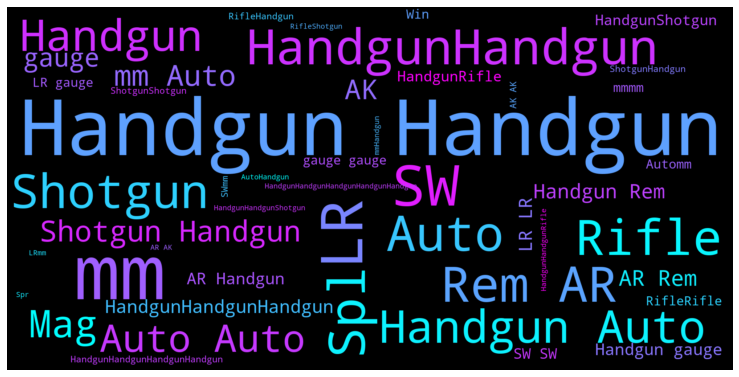

In [22]:
# types of guns used
df["gun_stolen"] = df['gun_stolen'].str.replace("Unknown|[0-9]|[|:]|","")
df["gun_type"]   = df["gun_type"].str.replace("Unknown|[0-9]|[|:]|","")
gn = df[df["gun_type"].notnull()]
w = WordCloud(background_color="black",colormap="cool",scale=5).generate(" ".join(gn["gun_type"]))
plt.figure(figsize=(13,8))
plt.imshow(w,interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
# key characteristics
from collections import Counter
big_text = "||".join(df['incident_characteristics'].dropna()).split("||")
incidents = Counter(big_text).most_common(20)
xx = [x[0] for x in incidents]
yy = [x[1] for x in incidents]

trace1 = go.Bar(
    x=yy[::-1],
    y=xx[::-1],
    name='Incident Characterisitcs',
    marker=dict(color='purple'),
    opacity=0.3,
    orientation="h"
)
data = [trace1]
layout = go.Layout(
    barmode='group',
    margin=dict(l=350),
    width=800,
    height=600,
    legend=dict(dict(x=-.1, y=1.2)),
    title = 'Key Incident Characteristics',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

In [18]:
# prominent incidents
from collections import Counter
import re

total_incidents = []
for i, each_inc in enumerate(df['incident_characteristics'].fillna('Not Available')):
    split_vals = [x for x in re.split('\|', each_inc) if len(x)>0]
    total_incidents.append(split_vals)
    if i == 0:
        unique_incidents = Counter(split_vals)
    else:
        for x in split_vals:
            unique_incidents[x] +=1

unique_incidents = pd.DataFrame.from_dict(unique_incidents, orient='index')
colvals = unique_incidents[0].sort_values(ascending=False).index.values
find_val = lambda searchList, elem: [[i for i, x in enumerate(searchList) if (x == e)][0] for e in elem]

a = np.zeros((df.shape[0], len(colvals)))
for i, incident in enumerate(total_incidents):
    aval = find_val(colvals, incident)
    a[i, np.array(aval)] = 1
incident = pd.DataFrame(a, index=df.index, columns=colvals)
prominent_incidents = incident.sum()[[4, 5, 6, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20,
                                      21, 23]]
fig = {
    'data': [
        {
            'labels': prominent_incidents.index,
            'values': prominent_incidents,
            'type': 'pie',
            'hoverinfo':'label+percent',
            "domain": {"x": [0, .45]},
        }
    ],
    'layout': {'title': 'Prominent Incidents of Gun Violence',
               'showlegend': True}
}
iplot(fig)

In [19]:
# 10 serious incidents
df1 = df.sort_values(['loss'], ascending=[False])
df1[['date', 'state', 'city_or_county', 'address', 'n_killed', 'n_injured']].head(10)

,date,state,city_or_county,address,n_killed,n_injured
239677,2017-10-01,Nevada,Las Vegas,Mandalay Bay 3950 Blvd S,59,489
130448,2016-06-12,Florida,Orlando,1912 S Orange Avenue,50,53
217151,2017-11-05,Texas,Sutherland Springs,216 4th St,27,20
101531,2015-12-02,California,San Bernardino,1365 South Waterman Avenue,16,19
232745,2018-02-14,Florida,Pompano Beach (Parkland),5901 Pine Island Rd,17,17
70511,2015-05-17,Texas,Waco,4671 S Jack Kultgen Fwy,9,18
195845,2017-07-01,Arkansas,Little Rock,220 W 6th St,0,25
137328,2016-07-25,Florida,Fort Myers,3580 Evans Ave,2,19
11566,2014-04-02,Texas,Fort Hood,Motor Pool Road and Tank Destroyer Boulevard,4,16
92624,2015-10-01,Oregon,Roseburg,1140 Umpqua College Rd,10,9


C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:1627: MatplotlibDeprecationWarning:

Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



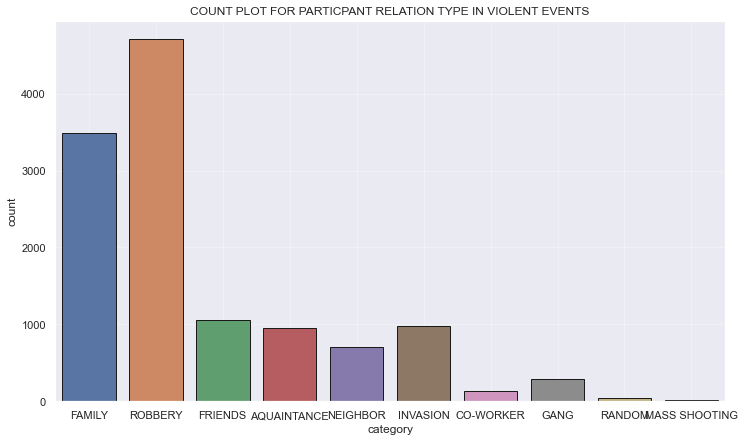

In [20]:
# relationship of participants
relation = df['participant_relationship']
relation = relation[relation.notnull()]
relation = relation.str.replace("[:|0-9]"," ").str.upper()
relation1 = pd.DataFrame({"count":[len(relation[relation.str.contains("FAMILY")]),
               len(relation[relation.str.contains("ROBBERY")]),
               len(relation[relation.str.contains("FRIENDS")]),
               len(relation[relation.str.contains("AQUAINTANCE")]),
               len(relation[relation.str.contains("NEIGHBOR")]),
               len(relation[relation.str.contains("INVASION")]),
               len(relation[relation.str.contains("CO-WORKER")]),
               len(relation[relation.str.contains("GANG")]),
               len(relation[relation.str.contains("RANDOM")]),
               len(relation[relation.str.contains("MASS SHOOTING")])],
              "category":["FAMILY","ROBBERY","FRIENDS","AQUAINTANCE","NEIGHBOR","INVASION","CO-WORKER","GANG","RANDOM","MASS SHOOTING"]})
relation1
plt.figure(figsize=(12,7))
sns.barplot("category","count",data=relation1,
            linewidth =1 ,edgecolor = "k" *relation1["category"].nunique())
plt.title("COUNT PLOT FOR PARTICPANT RELATION TYPE IN VIOLENT EVENTS")
plt.grid(True,alpha=.3)
plt.show()

In [21]:
# gender groups
## find gender groups 
suspect_age_groups = {}
victim_age_groups = {}
for i, row in df.iterrows():
    suspects = []
    for k,v in row['participant_type_map'].items():
        if "suspect" in v.lower():
            suspects.append(k)
    for suspect in suspects:
        if suspect in row['participant_gender_map']:
            ag = row['participant_gender_map'][suspect]
            if ag not in suspect_age_groups:
                suspect_age_groups[ag] = 0 
            else:
                suspect_age_groups[ag] += 1
                        
    victims = []
    for k,v in row['participant_type_map'].items():
        if "victim" in v.lower():
            victims.append(k)
    for victim in victims:
        if victim in row['participant_gender_map']:
            ag = row['participant_gender_map'][victim]
            if ag not in victim_age_groups:
                victim_age_groups[ag] = 0 
            else:
                victim_age_groups[ag] += 1
                
del victim_age_groups['Male, female']
fig = {
  "data": [
    {
      "values": list(suspect_age_groups.values()),
      "labels": list(suspect_age_groups.keys()),
      "marker" : dict(colors=['#fc76bb','#b4a9f9']),
      "name": "Suspects",
      "domain": {"x": [0, .48]},
      "hoverinfo":"label+percent+name",
      "hole": .7,
      "type": "pie"
    },
    {
      "values": list(victim_age_groups.values()),
      "labels": list(victim_age_groups.keys()),
      "text": ["Victims"],
      "marker" : dict(colors=['#b4a9f9','#fc76bb']),
      "textposition":"inside",
      "domain": {"x": [.52, 1]},
      "name": "Victims",
      "hoverinfo":"label+percent+name",
      "hole": .7,
      "type": "pie"
    }],
  "layout": {
          "showlegend" : False,
        "title":"Genders of People Involved",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Suspects",
                "x": 0.20,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Victims",
                "x": 0.8,
                "y": 0.5
            }
        ]
    }
}
iplot(fig, filename='donut')